# 1. Setup

In [2]:
# a temporary solution, run twice to set the current path as '../Fair-RL/src'
%cd ..

/Users/xiaohui/Documents/Code/Fair-RL


In [3]:
%cd src

/Users/xiaohui/Documents/Code/Fair-RL/src


In [4]:
# used to auto-reload imported module after making modification inside .py files
%load_ext autoreload
%autoreload 2

## 1.1 imports

In [5]:
from experiments.configs.base import params
from env.mrp_env_rccc import MachineReplacement
from solver.ggf_dlp import build_dlp, extract_dlp, solve_dlp
from utils.common import MDP4LP
from utils.mrp import MRPData
from utils.policy import calculate_state_value
import pandas as pd
import numpy as np
from utils.encoding import state_vector_to_int_index, state_int_index_to_vector
import matplotlib.pyplot as plt
import seaborn as sns

## 1.2 check parameters

In [9]:
params.weight_type = 'exponential2'

In [10]:
# set parameters
params.num_actions = 2
params.num_states = 3
params.num_groups = 3

mrp_data = MRPData(
    num_groups=params.num_groups,
    num_states=params.num_states,
    num_actions=params.num_actions,
    prob_remain=params.prob_remain,
    weight_type=params.weight_type,
    cost_types_operation=params.cost_type_operation,
    cost_types_replace=params.cost_type_replace,
)

mdp = MDP4LP(
    num_states=mrp_data.num_global_states,
    num_actions=mrp_data.num_global_actions,
    num_groups=mrp_data.num_groups,
    transition=mrp_data.global_transitions,
    costs=mrp_data.global_costs,
    discount=params.gamma,
    weights=mrp_data.weights,
    minimize=True,
    encoding_int=False,
    base_num_states=params.num_states,
)

In [11]:
params

{'num_actions': 2,
 'num_states': 3,
 'num_groups': 3,
 'ggi': True,
 'rccc_wrt_max': 0.5,
 'mat_type': 1,
 'weight_type': 'exponential2',
 'cost_type_operation': 'quadratic',
 'cost_type_replace': 'rccc',
 'prob_remain': 0.8,
 'num_opt_solutions': 1,
 'num_episodes': 1000,
 'len_episode': 100,
 'num_samples': 10,
 'gamma': 0.95,
 'seed': 0,
 'prob1_state_idx': None,
 'deterministic_policy': False,
 'ql': {'alpha': 0.3,
  'epsilon': 0.7,
  'decaying_factor': 0.95,
  'deterministic': False},
 'dqn': {'h_size': 64,
  'alpha': 0.0001,
  'epsilon': 0.6,
  'decaying_factor': 0.95,
  'deterministic': False,
  'encoding_int': False}}

### 1.2.1 Non-GGF Data

In [12]:
mrp_datanoGGF = MRPData(
    num_groups=params.num_groups,
    num_states=params.num_states,
    num_actions=params.num_actions,
    prob_remain=params.prob_remain,
    weight_type="uniform",
    cost_types_operation=params.cost_type_operation,
    cost_types_replace=params.cost_type_replace,
)

mdpnoGGF = MDP4LP(
    num_states=mrp_data.num_global_states,
    num_actions=mrp_data.num_global_actions,
    num_groups=mrp_data.num_groups,
    transition=mrp_data.global_transitions,
    costs=mrp_data.global_costs,
    discount=params.gamma,
    weights=mrp_data.weights,
    minimize=True,
    encoding_int=False,
    base_num_states=params.num_states,
)

## 1.3 Notations

In [13]:
uniform_dist = [1 / mrp_data.num_global_states for i in range(mrp_data.num_global_states)]

In [626]:
str(np.array(uniform_perm_state).round(4))

'[0.     0.     0.     0.     0.     0.1667 0.     0.1667 0.     0.\n 0.     0.1667 0.     0.     0.     0.1667 0.     0.     0.     0.1667\n 0.     0.1667 0.     0.     0.     0.     0.    ]'

In [ ]:
uniform_perm_state

# 2. Important Funtions

## 2.1 Solve LP and Calculate V

In [15]:
def solve_lp_and_calculate_v(initial_mu = None, print_results=False):
    # calculate LP values
    model = build_dlp(mdp=mdp, initial_mu=initial_mu)
    # Solve the GGF model
    _, model, _ = solve_dlp(model=model)
    results = extract_dlp(model=model, print_results=print_results)

    initial_state_prob = model.init_distribution
    policy = results.policy

    # calculate the state value
    state_value_list = calculate_state_value(
        discount=params.gamma,
        initial_state_prob=initial_state_prob,
        policy=policy.to_numpy(),
        reward_or_cost=mrp_data.global_costs,
        transition_prob=mrp_data.global_transitions,
        time_horizon=params.num_episodes,
    )
    
    GGF_value_list = []
    for t in range(params.len_episode):
        GGF_value_list.append(np.dot(mrp_data.weights, sorted(state_value_list[t])))
    return state_value_list, GGF_value_list, results

In [125]:
def solve_no_ggf_lp_and_calculate_v(prob1_state_idx):
    
    # calculate LP values
    model = build_dlp(mdp=mdpnoGGF, prob1_state_idx = prob1_state_idx)
    # Solve the GGF model
    _, model, _ = solve_dlp(model=model)
    results = extract_dlp(model=model, print_results=True)

    initial_state_prob = model.init_distribution
    policy = results.policy

    # calculate the state value
    state_value_list = calculate_state_value(
        discount=params.gamma,
        initial_state_prob=initial_state_prob,
        policy=policy.to_numpy(),
        reward_or_cost=mrp_data.global_costs,
        transition_prob=mrp_data.global_transitions,
        time_horizon=params.num_episodes,
    )
    return state_value_list, results

## 2.2 Construct the bar policy for any policy

In [637]:
def construct_bar_policy(policy=None):
    if not policy:
        random_policy = np.random.random((mrp_data.num_global_states,mrp_data.num_global_actions))
        # normalize the policy
        random_policy = random_policy / random_policy.sum(axis=1)[:,None]
        random_policy = pd.DataFrame(random_policy, index=results.policy.index, columns = ['(0, 0, 0)', '(1, 0, 0)', '(0, 1, 0)', '(0, 0, 1)'])
        # random_policy
    else:
        random_policy = policy
    
    # construct the policy
    perm_policy_list = np.zeros((len(perm_state_list), mrp_data.num_global_states, mrp_data.num_global_actions))
    
    for idx in range(len(all_permutation_matrix)):
        # get the action permutation matrix
        perm_action = np.zeros((params.num_groups+1, params.num_groups+1))
        perm_action[0, 0] = 1
        perm_action[1:, 1:] = all_permutation_matrix[idx]
        temp_policy = np.zeros((mrp_data.num_global_states, mrp_data.num_global_actions))
        for s_idx in range(mrp_data.num_global_states):
            # get the permutated state index
            s_vector = state_int_index_to_vector(state_int_index=s_idx, num_groups=params.num_groups, num_states=params.num_states)
            perm_s_vector = np.matmul(s_vector, all_permutation_matrix[idx])
            perm_s_idx = state_vector_to_int_index(state_vector=perm_s_vector, num_states=params.num_states)
            temp_policy[perm_s_idx, :] = np.matmul(random_policy.iloc[s_idx], perm_action)
        perm_policy_list[idx, :, :] = temp_policy
    bar_policy = np.mean(perm_policy_list, axis=0)
    bar_policy_pd = pd.DataFrame(bar_policy, index= results.policy.index)

    # calculate the state value
    uniform_dist = [1 / mrp_data.num_global_states for i in range(mrp_data.num_global_states)]
    assert sum(uniform_dist) -1 <1e-6
    state_value_bar = calculate_state_value(
        discount=params.gamma,
        initial_state_prob=uniform_perm_state,
        policy=bar_policy,
        reward_or_cost=mrp_data.global_costs,
        transition_prob=mrp_data.global_transitions,
        time_horizon=params.num_episodes,
    )
    # calculate the state value
    state_value_random = calculate_state_value(
        discount=params.gamma,
        initial_state_prob=uniform_perm_state,
        policy=random_policy.to_numpy(),
        reward_or_cost=mrp_data.global_costs,
        transition_prob=mrp_data.global_transitions,
        time_horizon=params.num_episodes,
    )
    return bar_policy_pd, random_policy, state_value_bar, state_value_random

# 3. Construct Bar policy

In [25]:
from utils.permutation import generate_permutation_matrix_group
all_permutation_matrix = generate_permutation_matrix_group(params.num_groups)
inverse_permutation_matrix = [np.linalg.inv(permM) for permM in all_permutation_matrix]

## 3.1 Starts uniformly

Given state [0, 1, 2], this means we start uniformly from all of its state permutation groups:

[0, 1, 2]; [0, 2, 1]; [1, 0, 2]; [1, 2, 0]; [2, 1, 0]; [2, 0, 1]


In [23]:
state = np.array([0, 1, 2])
params.num_groups = 3
params.len_episode = 300

In [26]:
## uniformly start
perm_state_list = [np.matmul(state, p_matrix) for p_matrix in all_permutation_matrix]
perm_state_idx_list = [state_vector_to_int_index(perm_state, params.num_states) for perm_state in perm_state_list]
# calculate initial state probability
uniform_perm_state = [0] * mrp_data.num_global_states
for idx in perm_state_idx_list:
    uniform_perm_state[idx] += 1/len(perm_state_idx_list)
assert sum(uniform_perm_state) - 1 < 1e-1
perm_state_list, str(uniform_perm_state)

([array([0, 1, 2]),
  array([0, 2, 1]),
  array([1, 0, 2]),
  array([2, 0, 1]),
  array([1, 2, 0]),
  array([2, 1, 0])],
 '[0, 0, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0, 0]')

In [277]:
state_value_uniform, _, results_uniform = solve_lp_and_calculate_v(initial_mu = uniform_perm_state, print_results=True)

Initial distribution:  [0, 0, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0, 0]
Solver solving time: 0.0863
Number of solutions found: 1
Proportion of stochastic policy: 13.79%
Policy:                            Var X:              Costs - Group 1 | Group 2                            
           0     1     2     3          0       1       2       3           0    1     2     3   
(0, 0, 0)  1     0     0     0     1.0968       0       0       0        0.00  1.0  0.00  0.00   
(0, 0, 1)  1     0     0     0     1.5997       0       0       0        0.00  1.0  0.00  0.00   
(0, 0, 2)  0     0     0     1          0       0       0  0.4319        0.00  1.0  0.00  0.00   
(0, 1, 0)  1     0     0     0     1.6072       0       0       0        0.00  1.0  0.00  0.00   
(0, 1, 1)  1     0     0     0     1.8498       0       0       0        0.00  1.0  0.00  0

## 3.2 Starts uniquely

In [475]:
# start uniquely
unique_state_prob_list = []
for idx in perm_state_idx_list:
    initial_state_prob = [0] * mrp_data.num_global_states
    initial_state_prob[idx] = 1
    unique_state_prob_list.append(initial_state_prob)
    print(str(initial_state_prob))

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [526]:
policy = []
policy_np = np.zeros((len(perm_state_list), mrp_data.num_global_states, mrp_data.num_global_actions))
idx = 0
for initial_mu in unique_state_prob_list:
    # calculate LP values
    model = build_dlp(mdp=mdp, initial_mu=initial_mu)
    # Solve the GGF model
    _, model, _ = solve_dlp(model=model)
    results = extract_dlp(model=model, print_results=False)
    # get the policy
    policy.append(results.policy.to_numpy())
    policy_np[idx, :, :] = results.policy.to_numpy()
    idx += 1

Initial distribution:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Solver solving time: 0.1007
Number of solutions found: 1
Initial distribution:  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Solver solving time: 0.0969
Number of solutions found: 1
Initial distribution:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Solver solving time: 0.0966
Number of solutions found: 1
Initial distribution:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Solver solving time: 0.0955
Number of solutions found: 1
Initial distribution:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Solver solving time: 0.0984
Number of solutions found: 1
Initial distribution:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Solver solving time: 0.0951
Number of solutions found: 1


In [529]:
# construct the bar policy
bar_policy012 = pd.DataFrame(np.mean(policy_np, axis=0), index = results.policy.index)
print(bar_policy012)

             0         1         2         3
(0, 0, 0)  1.0  0.000000  0.000000  0.000000
(0, 0, 1)  1.0  0.000000  0.000000  0.000000
(0, 0, 2)  0.0  0.000000  0.000000  1.000000
(0, 1, 0)  1.0  0.000000  0.000000  0.000000
(0, 1, 1)  1.0  0.000000  0.000000  0.000000
(0, 1, 2)  0.0  0.000000  0.000000  1.000000
(0, 2, 0)  0.0  0.000000  1.000000  0.000000
(0, 2, 1)  0.0  0.000000  1.000000  0.000000
(0, 2, 2)  0.0  0.000000  0.500000  0.500000
(1, 0, 0)  1.0  0.000000  0.000000  0.000000
(1, 0, 1)  1.0  0.000000  0.000000  0.000000
(1, 0, 2)  0.0  0.000000  0.000000  1.000000
(1, 1, 0)  1.0  0.000000  0.000000  0.000000
(1, 1, 1)  1.0  0.000000  0.000000  0.000000
(1, 1, 2)  0.0  0.000000  0.000000  1.000000
(1, 2, 0)  0.0  0.000000  1.000000  0.000000
(1, 2, 1)  0.0  0.000000  1.000000  0.000000
(1, 2, 2)  0.0  0.000000  0.500000  0.500000
(2, 0, 0)  0.0  1.000000  0.000000  0.000000
(2, 0, 1)  0.0  1.000000  0.000000  0.000000
(2, 0, 2)  0.0  0.500000  0.000000  0.500000
(2, 1, 0) 

In [531]:
# calculate the state value
state_value_list = calculate_state_value(
    discount=params.gamma,
    initial_state_prob=uniform_perm_state,
    policy=bar_policy012.to_numpy(),
    reward_or_cost=mrp_data.global_costs,
    transition_prob=mrp_data.global_transitions,
    time_horizon=params.num_episodes,
)
state_value_list[-1]

array([3.84633021, 3.84633021, 3.84633021])

In [187]:
# calculate LP values
model = build_dlp(mdp=mdp, initial_mu = uniform_perm_state)
# Solve the GGF model
_, model, _ = solve_dlp(model=model)
results = extract_dlp(model=model, print_results=True)

Initial distribution:  [0, 0, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0, 0]
Solver solving time: 0.0637
Number of solutions found: 1
Proportion of stochastic policy: 13.79%
Policy:                            Var X:              Costs - Group 1 | Group 2                            
           0     1     2     3          0       1       2       3           0    1     2     3        0     1    2     3
(0, 0, 0)  1     0     0     0     1.0968       0       0       0        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 0, 1)  1     0     0     0     1.5997       0       0       0        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 0, 2)  0     0     0     1          0       0       0  0.4319        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 1, 0)  1     0     0     0     1.6072       0       0       0        0.00  1.0  0.00  0.00   

# 3*. Follow-up: simulate the uniform policy

## 3.1 Simulate One Machine

### 3.1.1 Setup

In [132]:
# initial state
s_index = 0
num_samples = 100
params.len_episode = 500
num_groups = 1

mrp_data_n1 = MRPData(
    num_groups=num_groups,
    num_states=params.num_states,
    num_actions=params.num_actions,
    prob_remain=params.prob_remain,
    weight_type=params.weight_type,
    cost_types_operation=params.cost_type_operation,
    cost_types_replace=params.cost_type_replace,
)

mdp_n1 = MDP4LP(
    num_states=mrp_data_n1.num_global_states,
    num_actions=mrp_data_n1.num_global_actions,
    num_groups=num_groups,
    transition=mrp_data_n1.global_transitions,
    costs=mrp_data_n1.global_costs,
    discount=params.gamma,
    weights=mrp_data_n1.weights,
    minimize=True,
    encoding_int=False,
    base_num_states=params.num_states,
)

In [133]:
# calculate LP values
model = build_dlp(mdp=mdp_n1)
# Solve the GGF model
_, model, _ = solve_dlp(model=model)
results_n1 = extract_dlp(model=model, print_results=True)
# get the policy
policy_n1 = results_n1.policy

Initial distribution:  [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Solver solving time: 0.0042
Number of solutions found: 1
Proportion of stochastic policy: 0.0%
Policy:                    Var X:          Costs - Group 1 | Group 2                    
      0  1          0       1           0    1   
(0,)  1  0     8.2279       0        0.00  1.0   
(1,)  1  0     9.6124       0        0.17  1.0   
(2,)  0  1          0  2.1597        0.67  1.0   
    Var L Var N     Group Costs
0  3.7618   0.0          3.7618
Var X total: 20.0
GGF Value (DLP) L+N:  3.7618
GGF Value (DLP) XC:   3.7618


### 3.1.2 Simulation

In [323]:
params.gamma ** (300) <= 1e-6

True

In [546]:
num_samples = 500
params.len_episode = 300
V = np.zeros((num_samples, params.len_episode))
for n in range(num_samples):
    s_index = np.random.choice(range(mrp_data_n1.num_global_states))
    for t in range(params.len_episode):
        # select the action
        action_prob = policy_n1.iloc[s_index]
        action_idx = np.random.choice(range(len(action_prob)), p=action_prob)
        # calculate the reward
        reward = mrp_data_n1.global_costs[s_index, action_idx][0]
        V[n, t] += params.gamma ** t * reward
        # transit to the next state
        next_s_prob = mrp_data_n1.global_transitions[s_index, :, action_idx]
        next_s_index = np.random.choice(range(len(next_s_prob)), p=next_s_prob)
        s_index = next_s_index

#### N=500 (std0.0385)

In [341]:
V_mean_accum = np.cumsum(V, axis=1)

V_mean = np.mean(V_mean_accum, axis=0)
V_std_n = np.std(V_mean_accum, axis=0) / np.sqrt(num_samples)

print("Mean: ", round(V_mean[-1],4))
print("Std: ", round(V_std_n[-1],4))

Mean:  3.863
Std:  0.0385


Text(0.5, 1.0, 'Sample $N$=500')

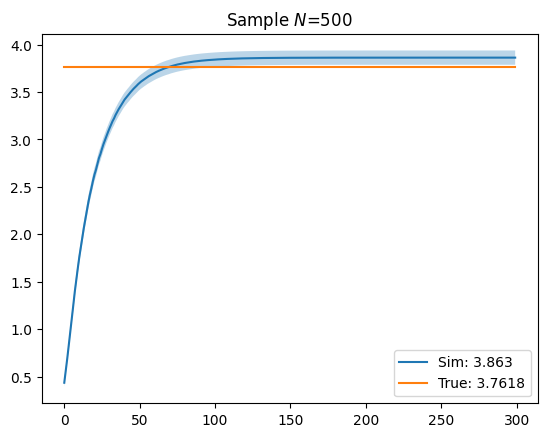

In [344]:
# samples: 500
sns.lineplot(V_mean, label=f'Sim: {round(V_mean[-1],4)}')
plt.fill_between(range(params.len_episode), V_mean - 1.96 * V_std_n, V_mean + 1.96 * V_std_n, alpha=0.3)
sns.lineplot(x=range(params.len_episode), y=results_n1.ggf_value_xc, label=f'True: {results_n1.ggf_value_xc}')
plt.title(f'Sample $N$={num_samples}')

Mean:  3.7815
Std:  0.0389


Text(0.5, 1.0, 'Sample $N$=500')

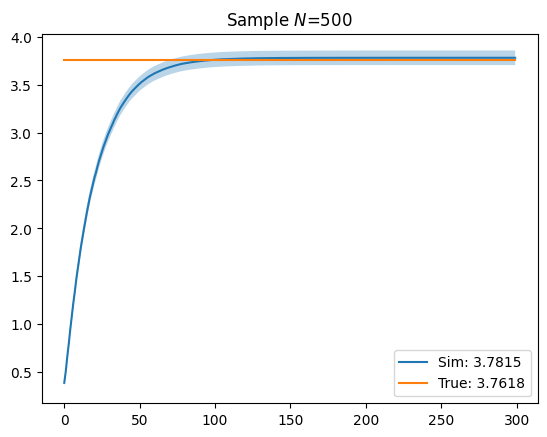

In [547]:
V_mean_accum = np.cumsum(V, axis=1)

V_mean = np.mean(V_mean_accum, axis=0)
V_std_n = np.std(V_mean_accum, axis=0) / np.sqrt(num_samples)

print("Mean: ", round(V_mean[-1],4))
print("Std: ", round(V_std_n[-1],4))

# samples: 500
sns.lineplot(V_mean, label=f'Sim: {round(V_mean[-1],4)}')
plt.fill_between(range(params.len_episode), V_mean - 1.96 * V_std_n, V_mean + 1.96 * V_std_n, alpha=0.3)
sns.lineplot(x=range(params.len_episode), y=results_n1.ggf_value_xc, label=f'True: {results_n1.ggf_value_xc}')
plt.title(f'Sample $N$={num_samples}')

#### N=1000 (std0.0276)

Mean:  3.796
Std:  0.0276


Text(0.5, 1.0, 'Sample $N$=1000')

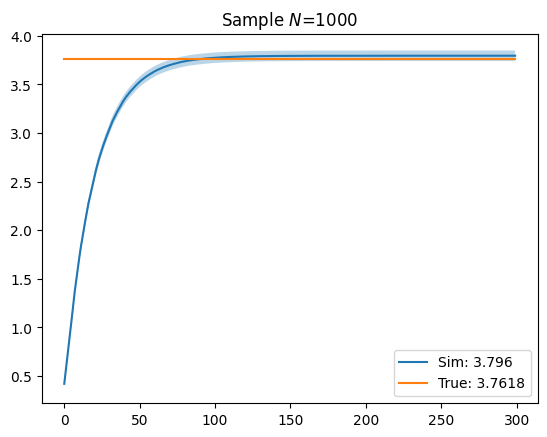

In [355]:
V_mean_accum = np.cumsum(V, axis=1)

V_mean = np.mean(V_mean_accum, axis=0)
V_std_n = np.std(V_mean_accum, axis=0) / np.sqrt(num_samples)
print("Mean: ", round(V_mean[-1],4))
print("Std: ", round(V_std_n[-1],4))

sns.lineplot(V_mean, label=f'Sim: {round(V_mean[-1],4)}')
plt.fill_between(range(params.len_episode), V_mean - 1.96 * V_std_n, V_mean + 1.96 * V_std_n, alpha=0.3)
sns.lineplot(x=range(params.len_episode), y=results_n1.ggf_value_xc, label=f'True: {results_n1.ggf_value_xc}')
plt.title(f'Sample $N$={num_samples}')

In [358]:
1.96 * V_std_n[-1]

0.054062234273262254

In [357]:
1.96 * V_std_n[-1] < 0.01

False

#### N=5000 (std0.0123)

Mean:  3.785
Std:  0.0123


Text(0.5, 1.0, 'Sample $N$=5000')

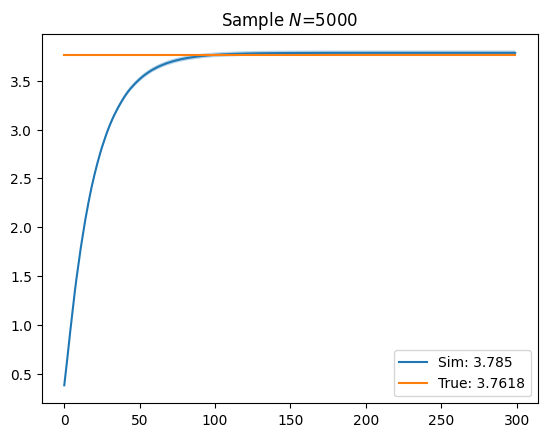

In [361]:
V_mean_accum = np.cumsum(V, axis=1)

V_mean = np.mean(V_mean_accum, axis=0)
V_std_n = np.std(V_mean_accum, axis=0) / np.sqrt(num_samples)
print("Mean: ", round(V_mean[-1],4))
print("Std: ", round(V_std_n[-1],4))

sns.lineplot(V_mean, label=f'Sim: {round(V_mean[-1],4)}')
plt.fill_between(range(params.len_episode), V_mean - 1.96 * V_std_n, V_mean + 1.96 * V_std_n, alpha=0.3)
sns.lineplot(x=range(params.len_episode), y=results_n1.ggf_value_xc, label=f'True: {results_n1.ggf_value_xc}')
plt.title(f'Sample $N$={num_samples}')

In [505]:
1.96 * 0.0123 /np.sqrt(5000)

0.00034093860561690574

In [362]:
1.96 * V_std_n[-1] < 0.01

False

In [363]:
V_mean[-1] - 1.96 * V_std_n[-1]<= results_n1.ggf_value_xc<= V_mean[-1] + 1.96 * V_std_n[-1]

True

#### N=10000 (std0.0086)

Mean:  3.7733
Std:  0.0086


Text(0.5, 1.0, 'Sample $N$=10000')

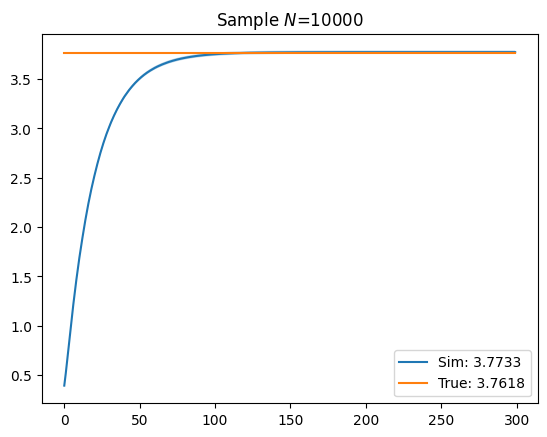

In [365]:
V_mean_accum = np.cumsum(V, axis=1)

V_mean = np.mean(V_mean_accum, axis=0)
V_std_n = np.std(V_mean_accum, axis=0) / np.sqrt(num_samples)
print("Mean: ", round(V_mean[-1],4))
print("Std: ", round(V_std_n[-1],4))

sns.lineplot(V_mean, label=f'Sim: {round(V_mean[-1],4)}')
plt.fill_between(range(params.len_episode), V_mean - 1.96 * V_std_n, V_mean + 1.96 * V_std_n, alpha=0.3)
sns.lineplot(x=range(params.len_episode), y=results_n1.ggf_value_xc, label=f'True: {results_n1.ggf_value_xc}')
plt.title(f'Sample $N$={num_samples}')

In [368]:
1.96 * V_std_n[-1] < 0.01

False

In [369]:
V_mean[-1] - 1.96 * V_std_n[-1]<= results_n1.ggf_value_xc<= V_mean[-1] + 1.96 * V_std_n[-1]

True

## 3.2 Simulate Multiple Machines

In [394]:
num_samples = 5000
params.len_episode = 300
temp_policy = results_uniform.policy
V = np.zeros((num_samples, params.num_groups, params.len_episode))
for n in range(num_samples):
    s_index = np.random.choice(range(mrp_data.num_global_states))
    for t in range(params.len_episode):
        # select the action
        action_prob = temp_policy.iloc[s_index]
        action_idx = np.random.choice(range(len(action_prob)), p=action_prob)
        # calculate the reward
        reward = mrp_data.global_costs[s_index, action_idx]
        V[n, :, t] += params.gamma ** t * reward
        # transit to the next state
        next_s_prob = mrp_data.global_transitions[s_index, :, action_idx]
        next_s_index = np.random.choice(range(len(next_s_prob)), p=next_s_prob)
        s_index = next_s_index

### 3.2.1 Simulation

In [494]:
def plot_figures(V, num_samples, results):
    V_mean_accum = np.cumsum(V, axis=2)

    V_mean = np.mean(V_mean_accum, axis=0).round(4)
    V_std_n = np.std(V_mean_accum, axis=0) / np.sqrt(num_samples)
    
    print("Mean: ", V_mean[:, -1])
    print("Std:  ", V_std_n[:, -1].round(4))
    inside = True    
    for g in range(params.num_groups):
        if V_mean[g,-1] - 1.96 * V_std_n[g,-1]<= results_uniform.costs[g]<= V_mean[g,-1] + 1.96 * V_std_n[g,-1]:
            pass
        else:
            inside = False
        sns.lineplot(x=range(params.len_episode), y=V_mean[g,:], label=f'Group {g}: {round(V_mean[g,-1],4)}')
        plt.fill_between(range(params.len_episode), V_mean[g] - 1.96 * V_std_n[g], V_mean[g] + 1.96 * V_std_n[g], alpha=0.3)
        sns.lineplot(x=range(params.len_episode), y=results.costs[g], label=f'True GGF-V: {results.costs[g]}')
    # sns.lineplot(x=range(params.len_episode), y=results_uniform.costs[0], label=f'True GGF-V: {results_uniform.costs[0]}')
    plt.title(f'Sample $N$={num_samples}')
    print("Inside Interval: ", inside)

#### N=500

In [291]:
# True Values
results_uniform.costs

array([3.8463, 3.8463, 3.8463])

Mean:  [3.8862 3.8542 3.9598]
Std:   [0.0397 0.0422 0.0422]
Inside Inverval:  True


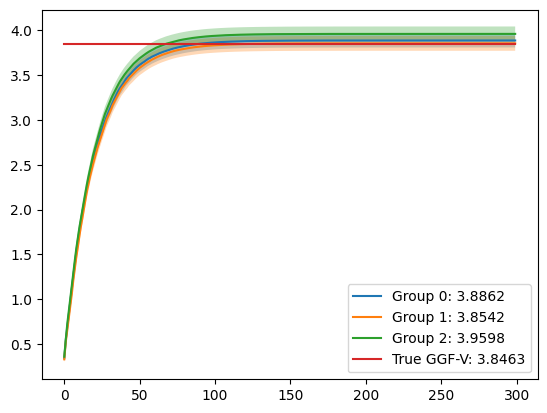

In [393]:
plot_figures(V)

#### N=5000

Mean:  [3.9035 3.8895 3.9023]
Std:   [0.0131 0.0131 0.0132]
Inside Inverval:  True


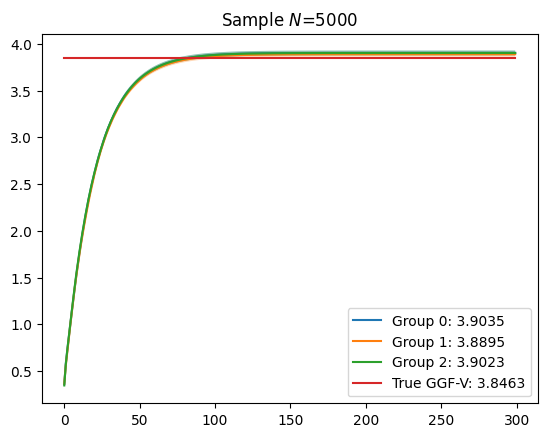

In [396]:
plot_figures(V)

In [503]:
1.96*0.0131 /np.sqrt(5000)

0.00036311347427491587

## 3.3 Simulate Permutation

In [402]:
from utils.policy import simulate_permuted_state_value

In [534]:
# initial state
params.num_samples = 1000
params.len_episode = 300
# simulate the permuted state value
Vt1000_012 = simulate_permuted_state_value(
    params=params,
    # policy=results_uniform.policy,
    policy=bar_policy012,
    mrp_data=mrp_data,
    initial_state_prob=unique_state_prob_list[0],
    all_permutation_matrix=all_permutation_matrix
)

Mean:  [3.7294 3.8859 3.8212]
Std:   [0.0945 0.0861 0.0901]
Inside Interval:  True


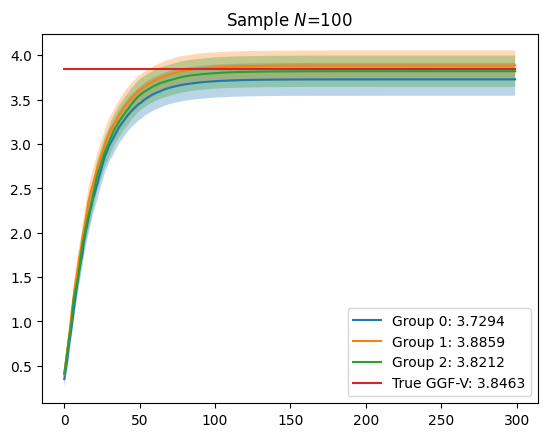

In [430]:
plot_figures(Vt100, 100)

Mean:  [3.795  3.8946 3.7991]
Std:   [0.0623 0.0707 0.0683]
Inside Interval:  True


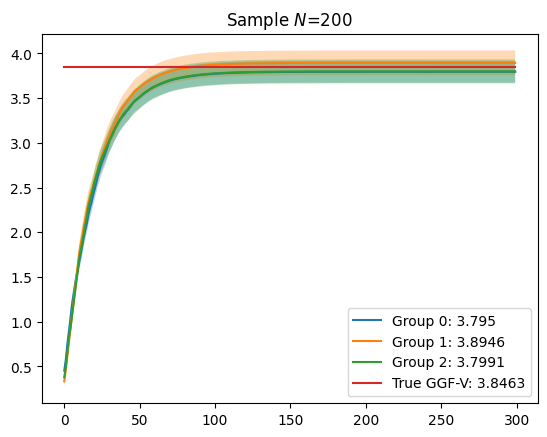

In [431]:
plot_figures(Vt200,200)

#### N=500

Mean:  [3.8253 3.7931 3.8564]
Std:   [0.0444 0.0424 0.0406]
Inside Interval:  True


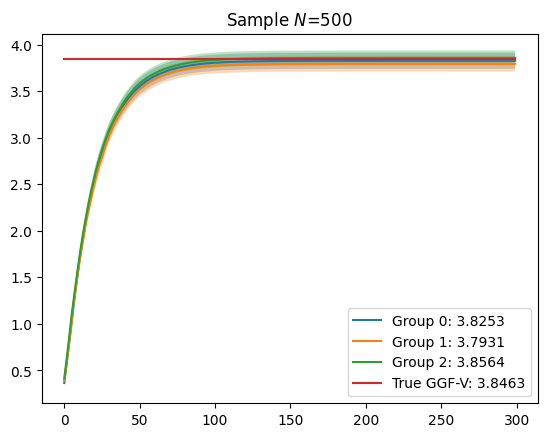

In [432]:
plot_figures(Vt500,500)

In [401]:
uniform_results.costs

array([3.8463, 3.8463, 3.8463])

#### N=5000

Mean:  [3.864  3.8674 3.8339]
Std:   [0.0131 0.0133 0.0131]
Inside Interval:  True


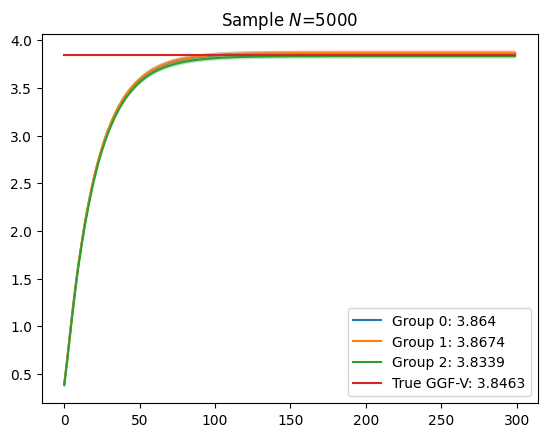

In [433]:
plot_figures(Vt5000,5000)

In [506]:
0.0131 * 1.96

0.025676

### results012

In [517]:
# calculate LP values
model012 = build_dlp(mdp=mdp, initial_mu=unique_state_prob_list[0])
# Solve the GGF model
_, model012, _ = solve_dlp(model=model012)
results012 = extract_dlp(model=model012, print_results=True)
# get the policy
policy012 = results012.policy

Initial distribution:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Solver solving time: 0.1016
Number of solutions found: 1
Proportion of stochastic policy: 0.0%
Policy:                            Var X:              Costs - Group 1 | Group 2                            
           0  1  2  3          0       1       2       3           0    1     2     3        0     1    2     3
(0, 0, 0)  1  0  0  0     1.0968       0       0       0        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 0, 1)  1  0  0  0     1.3142       0       0       0        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 0, 2)  0  0  0  1          0       0       0    0.26        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 1, 0)  1  0  0  0     2.2334       0       0       0        0.00  1.0  0.00  0.00     0.17  0.17  1.0  0.17
(0, 1, 1)  1  0  0  0      2.013       0       0       0        0.00  1.0  0.00  0.00     0.17  0.17  1.0  0.17
(0, 1, 2)  0  0  0 

In [521]:
results012.costs.mean().round(4)

3.8463

In [525]:
np.mean([3.6012, 3.8016, 4.1174])

3.8400666666666665

Mean:  [3.6012 3.8016 4.1174]
Std:   [0.0292 0.0294 0.0294]
Inside Interval:  False


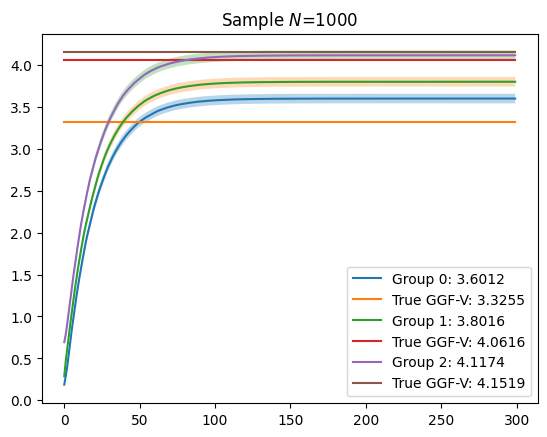

In [501]:
plot_figures(Vt1000_012, 1000, results012)

## 3.4 Closed-Form Calculation

In [53]:
# calculate the state value
all_perm_state_value = []
for init_prob in unique_state_prob_list:
    temp_state_value_list = calculate_state_value(
        discount=params.gamma,
        initial_state_prob=init_prob,
        policy=results_uniform.policy.to_numpy(),
        reward_or_cost=mrp_data.global_costs,
        transition_prob=mrp_data.global_transitions,
        time_horizon=params.num_episodes,
    )
    all_perm_state_value.append(temp_state_value_list[-1])
all_perm_state_value

[array([3.23606887, 4.0682404 , 4.23468137]),
 array([3.23602761, 4.23337631, 4.06958672]),
 array([4.06688763, 3.23737453, 4.23472847]),
 array([4.23602761, 3.23337631, 4.06958672]),
 array([4.06688763, 4.23737453, 3.23472847]),
 array([4.23606887, 4.0682404 , 3.23468137])]

In [56]:
# check permutation
state_value_012 = all_perm_state_value[0]
for idx in range(len(inverse_permutation_matrix)):
    inverse_state_value = np.matmul(all_perm_state_value[idx], inverse_permutation_matrix[idx])
    print(inverse_state_value.all() == state_value_012.all())

True
True
True
True
True
True


# 4. Random policy

In [434]:
random_policy = np.random.random((mrp_data.num_global_states,mrp_data.num_global_actions))
# normalize the policy
random_policy = random_policy / random_policy.sum(axis=1)[:,None]
random_policy = pd.DataFrame(random_policy, index=results.policy.index, columns = ['(0, 0, 0)', '(1, 0, 0)', '(0, 1, 0)', '(0, 0, 1)'])
random_policy

,"(0, 0, 0)","(1, 0, 0)","(0, 1, 0)","(0, 0, 1)"
"(0, 0, 0)",0.149662,0.264559,0.255183,0.330596
"(0, 0, 1)",0.316097,0.243847,0.370723,0.069333
"(0, 0, 2)",0.458062,0.372350,0.136381,0.033208
"(0, 1, 0)",0.428033,0.339702,0.168156,0.064110
"(0, 1, 1)",0.477662,0.053199,0.099917,0.369222
"(0, 1, 2)",0.263159,0.291919,0.407088,0.037834
"(0, 2, 0)",0.098332,0.239274,0.362608,0.299786
"(0, 2, 1)",0.106056,0.140445,0.374813,0.378686
"(0, 2, 2)",0.034291,0.600649,0.338225,0.026835
"(1, 0, 0)",0.224148,0.058693,0.429504,0.287655


In [550]:
# construct the policy
perm_policy_list = np.zeros((len(perm_state_list), mrp_data.num_global_states, mrp_data.num_global_actions))

for idx in range(len(all_permutation_matrix)):
    # get the action permutation matrix
    perm_action = np.zeros((params.num_groups+1, params.num_groups+1))
    perm_action[0, 0] = 1
    perm_action[1:, 1:] = all_permutation_matrix[idx]
    temp_policy = np.zeros((mrp_data.num_global_states, mrp_data.num_global_actions))
    for s_idx in range(mrp_data.num_global_states):
        # get the permutated state index
        s_vector = state_int_index_to_vector(state_int_index=s_idx, num_groups=params.num_groups, num_states=params.num_states)
        perm_s_vector = np.matmul(s_vector, all_permutation_matrix[idx])
        perm_s_idx = state_vector_to_int_index(state_vector=perm_s_vector, num_states=params.num_states)
        temp_policy[perm_s_idx, :] = np.matmul(random_policy.iloc[s_idx], perm_action)
    perm_policy_list[idx, :, :] = temp_policy
bar_policy = np.mean(perm_policy_list, axis=0)
bar_policy_pd = pd.DataFrame(bar_policy, index= results.policy.index)
bar_policy_pd

,0,1,2,3
"(0, 0, 0)",0.149662,0.283446,0.283446,0.283446
"(0, 0, 1)",0.322759,0.289257,0.289257,0.098727
"(0, 0, 2)",0.215705,0.267987,0.267987,0.248320
"(0, 1, 0)",0.322759,0.289257,0.098727,0.289257
"(0, 1, 1)",0.406289,0.130305,0.231703,0.231703
"(0, 1, 2)",0.228384,0.304732,0.237865,0.229020
"(0, 2, 0)",0.215705,0.267987,0.248320,0.267987
"(0, 2, 1)",0.228384,0.304732,0.229020,0.237865
"(0, 2, 2)",0.268560,0.396776,0.167332,0.167332
"(1, 0, 0)",0.322759,0.098727,0.289257,0.289257


In [455]:
# calculate the state value
initial_state_prob = [0] * mrp_data.num_global_states
initial_state_prob[0] = 1

In [445]:
uniform_state_prob = [1/mrp_data.num_global_states] * mrp_data.num_global_states
assert sum(uniform_state_prob) -1 <1e-6

In [556]:
state_value_list_random = calculate_state_value(
    discount=params.gamma,
    initial_state_prob=uniform_state_prob,
    policy=random_policy.to_numpy(),
    reward_or_cost=mrp_data.global_costs,
    transition_prob=mrp_data.global_transitions,
    time_horizon=params.num_episodes,
)
state_value_list_random[-1].round(4)

array([8.1338, 8.41  , 8.6231])

In [557]:
# uniform on all: [1/n] * n
# calculate the state value
state_value_list_uniform = calculate_state_value(
    discount=params.gamma,
    initial_state_prob=uniform_state_prob,
    policy=bar_policy,
    reward_or_cost=mrp_data.global_costs,
    transition_prob=mrp_data.global_transitions,
    time_horizon=params.num_episodes,
)
state_value_list_uniform[-1].round(4)

array([8.1454, 8.1454, 8.1454])

In [558]:
np.mean(state_value_list_random[-1]).round(4)

8.389

In [552]:
# calculate the state value
state_value_list_uniform = calculate_state_value(
    discount=params.gamma,
    initial_state_prob=uniform_perm_state,
    policy=bar_policy,
    reward_or_cost=mrp_data.global_costs,
    transition_prob=mrp_data.global_transitions,
    time_horizon=params.num_episodes,
)
state_value_list_uniform[-1]

array([8.15581473, 8.15581473, 8.15581473])

In [90]:
state_value = np.zeros(params.num_groups)
num_runs = 100
for n in range(num_runs):
    bar_policy_pd, state_value_list = construct_bar_policy()
    state_value += state_value_list[-1]
state_value/num_runs

array([7.92249035, 7.92249035, 7.92249035])

#### optimal policy

In [593]:
s_value_uniform, _, r_uniform = solve_lp_and_calculate_v(print_results=True)

Initial distribution:  [0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035]
Solver solving time: 0.1665
Number of solutions found: 1
Proportion of stochastic policy: 13.79%
Policy:                            Var X:              Costs - Group 1 | Group 2                            
           0     1     2    3          0       1       2       3           0    1     2     3        0     1    2     3
(0, 0, 0)  1     0     0    0     1.2698       0       0

In [614]:
print(bar_policy_star)

             0         1         2         3
(0, 0, 0)  1.0  0.000000  0.000000  0.000000
(0, 0, 1)  1.0  0.000000  0.000000  0.000000
(0, 0, 2)  0.0  0.000000  0.000000  1.000000
(0, 1, 0)  1.0  0.000000  0.000000  0.000000
(0, 1, 1)  1.0  0.000000  0.000000  0.000000
(0, 1, 2)  0.0  0.000000  0.000000  1.000000
(0, 2, 0)  0.0  0.000000  1.000000  0.000000
(0, 2, 1)  0.0  0.000000  1.000000  0.000000
(0, 2, 2)  0.0  0.000000  0.500000  0.500000
(1, 0, 0)  1.0  0.000000  0.000000  0.000000
(1, 0, 1)  1.0  0.000000  0.000000  0.000000
(1, 0, 2)  0.0  0.000000  0.000000  1.000000
(1, 1, 0)  1.0  0.000000  0.000000  0.000000
(1, 1, 1)  1.0  0.000000  0.000000  0.000000
(1, 1, 2)  0.0  0.000000  0.000000  1.000000
(1, 2, 0)  0.0  0.000000  1.000000  0.000000
(1, 2, 1)  0.0  0.000000  1.000000  0.000000
(1, 2, 2)  0.0  0.000000  0.500000  0.500000
(2, 0, 0)  0.0  1.000000  0.000000  0.000000
(2, 0, 1)  0.0  1.000000  0.000000  0.000000
(2, 0, 2)  0.0  0.500000  0.000000  0.500000
(2, 1, 0) 

In [607]:
bar_policy_star, state_value_bar, state_value_star = construct_bar_policy(policy=r_uniform.policy)

In [611]:
state_value_bar[-1].round(4)

array([3.9031, 3.9031, 3.9031])

In [610]:
state_value_star[-1].round(4)

array([3.9031, 3.9031, 3.9031])

### G([0, 0, 0])

In [456]:
# calculate the state value
state_value_list_uniform = calculate_state_value(
    discount=params.gamma,
    initial_state_prob=initial_state_prob,
    policy=bar_policy,
    reward_or_cost=mrp_data.global_costs,
    transition_prob=mrp_data.global_transitions,
    time_horizon=params.num_episodes,
)
state_value_list_uniform[-1]

array([7.44818448, 7.44818448, 7.44818448])

### G([0, 1, 2])

In [462]:
str(np.array(uniform_perm_state).round(4))

'[0.     0.     0.     0.     0.     0.1667 0.     0.1667 0.     0.\n 0.     0.1667 0.     0.     0.     0.1667 0.     0.     0.     0.1667\n 0.     0.1667 0.     0.     0.     0.     0.    ]'

In [464]:
str(unique_state_prob_list)

'[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]'

In [509]:
# calculate the state value
state_value_list_uniform = calculate_state_value(
    discount=params.gamma,
    initial_state_prob=uniform_perm_state,
    policy=bar_policy,
    reward_or_cost=mrp_data.global_costs,
    transition_prob=mrp_data.global_transitions,
    time_horizon=params.num_episodes,
)
state_value_list_uniform[-1].round(4)

array([8.1558, 8.1558, 8.1558])

In [511]:
for unique_state_prob in unique_state_prob_list:
    state_value_list_unique = calculate_state_value(
        discount=params.gamma,
        initial_state_prob=unique_state_prob,
        policy=bar_policy,
        reward_or_cost=mrp_data.global_costs,
        transition_prob=mrp_data.global_transitions,
        time_horizon=params.num_episodes,
    )
    print(state_value_list_unique[-1], "Mean:", np.mean(state_value_list_unique[-1]).round(4))

[7.54856295 8.00548532 8.91339592] Mean: 8.1558
[7.54856295 8.91339592 8.00548532] Mean: 8.1558
[8.00548532 7.54856295 8.91339592] Mean: 8.1558
[8.91339592 7.54856295 8.00548532] Mean: 8.1558
[8.00548532 8.91339592 7.54856295] Mean: 8.1558
[8.91339592 8.00548532 7.54856295] Mean: 8.1558


### with bar policy

In [562]:
all_state_values = np.zeros((mrp_data.num_global_states, 3))
for state in range(mrp_data.num_global_states):
    init_state_temp = [0] * mrp_data.num_global_states
    init_state_temp[state] = 1
    s_vector = state_int_index_to_vector(state_int_index=state, num_groups=params.num_groups, num_states=params.num_states)
    state_value_list_unique = calculate_state_value(
        discount=params.gamma,
        initial_state_prob=init_state_temp,
        policy=bar_policy,
        reward_or_cost=mrp_data.global_costs,
        transition_prob=mrp_data.global_transitions,
        time_horizon=params.num_episodes,
    )
    all_state_values[state, :] = state_value_list_unique[-1]
    print(str(s_vector), state_value_list_unique[-1].round(4), "Mean:", np.mean(state_value_list_unique[-1]).round(4))

[0 0 0] [7.4482 7.4482 7.4482] Mean: 7.4482
[0 0 1] [7.4538 7.4538 7.9145] Mean: 7.6074
[0 0 2] [7.4653 7.4653 8.875 ] Mean: 7.9352
[0 1 0] [7.4538 7.9145 7.4538] Mean: 7.6074
[0 1 1] [7.277  7.9745 7.9745] Mean: 7.742
[0 1 2] [7.5486 8.0055 8.9134] Mean: 8.1558
[0 2 0] [7.4653 8.875  7.4653] Mean: 7.9352
[0 2 1] [7.5486 8.9134 8.0055] Mean: 8.1558
[0 2 2] [7.748  9.0376 9.0376] Mean: 8.6077
[1 0 0] [7.9145 7.4538 7.4538] Mean: 7.6074
[1 0 1] [7.9745 7.277  7.9745] Mean: 7.742
[1 0 2] [8.0055 7.5486 8.9134] Mean: 8.1558
[1 1 0] [7.9745 7.9745 7.277 ] Mean: 7.742
[1 1 1] [7.9868 7.9868 7.9868] Mean: 7.9868
[1 1 2] [8.0244 8.0244 8.8766] Mean: 8.3085
[1 2 0] [8.0055 8.9134 7.5486] Mean: 8.1558
[1 2 1] [8.0244 8.8766 8.0244] Mean: 8.3085
[1 2 2] [8.0777 8.9097 8.9097] Mean: 8.6323
[2 0 0] [8.875  7.4653 7.4653] Mean: 7.9352
[2 0 1] [8.9134 7.5486 8.0055] Mean: 8.1558
[2 0 2] [9.0376 7.748  9.0376] Mean: 8.6077
[2 1 0] [8.9134 8.0055 7.5486] Mean: 8.1558
[2 1 1] [8.8766 8.0244 8.0244] Mean

In [564]:
all_state_values.mean().round(4)

8.1454

In [622]:
state_value_list_unique = calculate_state_value(
        discount=params.gamma,
        initial_state_prob=uniform_dist,
        policy=bar_policy,
        reward_or_cost=mrp_data.global_costs,
        transition_prob=mrp_data.global_transitions,
        time_horizon=params.num_episodes,
    )
state_value_list_unique[-1].round(4)

array([8.1454, 8.1454, 8.1454])

### with random policy

In [567]:
all_state_values = np.zeros((mrp_data.num_global_states, 3))
for state in range(mrp_data.num_global_states):
    init_state_temp = [0] * mrp_data.num_global_states
    init_state_temp[state] = 1
    s_vector = state_int_index_to_vector(state_int_index=state, num_groups=params.num_groups, num_states=params.num_states)
    state_value_list_unique = calculate_state_value(
        discount=params.gamma,
        initial_state_prob=init_state_temp,
        policy=random_policy.to_numpy(),
        reward_or_cost=mrp_data.global_costs,
        transition_prob=mrp_data.global_transitions,
        time_horizon=params.num_episodes,
    )
    all_state_values[state, :] = state_value_list_unique[-1]
    print(str(s_vector), state_value_list_unique[-1].round(4), "Mean:", np.mean(state_value_list_unique[-1]).round(4))

[0 0 0] [7.3637 7.7965 7.7618] Mean: 7.6407
[0 0 1] [7.4542 7.8609 8.5055] Mean: 7.9402
[0 0 2] [ 7.8894  7.4669 10.1456] Mean: 8.5006
[0 1 0] [7.4235 8.2235 7.3781] Mean: 7.6751
[0 1 1] [7.1421 8.1662 8.395 ] Mean: 7.9011
[0 1 2] [ 7.8089  8.1885 10.0465] Mean: 8.6813
[0 2 0] [7.2932 9.0344 7.8775] Mean: 8.0684
[0 2 1] [7.2873 8.9865 8.5859] Mean: 8.2866
[0 2 2] [ 8.3262  8.8799 10.1298] Mean: 9.112
[1 0 0] [7.7933 8.1364 7.6135] Mean: 7.8478
[1 0 1] [8.0454 7.8312 8.4301] Mean: 8.1022
[1 0 2] [8.181  8.0707 9.8528] Mean: 8.7015
[1 1 0] [7.8616 8.3645 7.3582] Mean: 7.8615
[1 1 1] [7.8887 8.3192 8.3481] Mean: 8.1853
[1 1 2] [8.0046 8.2111 9.0679] Mean: 8.4279
[1 2 0] [7.7754 9.4474 8.1672] Mean: 8.4634
[1 2 1] [8.0114 9.2998 8.555 ] Mean: 8.6221
[1 2 2] [8.0552 9.1714 9.4043] Mean: 8.877
[2 0 0] [8.6079 8.0614 7.4234] Mean: 8.0309
[2 0 1] [9.0625 8.0083 8.3884] Mean: 8.4864
[2 0 2] [9.4505 7.5207 9.9847] Mean: 8.9853
[2 1 0] [8.3587 8.2765 7.2813] Mean: 7.9722
[2 1 1] [8.7493 8.1613 8.

In [568]:
all_state_values.mean().round(4)

8.389

### 4.3 Compare random & bar policy

In [581]:
num_runs = 1000
compare_values = []
for n in range(num_runs):
    bar_policy_pd, state_value_bar, state_value_random = construct_bar_policy()
    compare_values.append(state_value_bar[-1].mean() < state_value_random[-1].mean())

In [578]:
sum(compare_values)/num_runs

1.0

In [638]:
num_runs = 1000
compare_values = []
for n in range(num_runs):
    bar_policy_pd, random_policy_pd, state_value_bar, state_value_random = construct_bar_policy()
    compare_values.append(state_value_bar[-1].mean() < state_value_random[-1].mean())
    if state_value_bar[-1].mean() >= state_value_random[-1].mean():
        break

In [639]:
state_value_bar[-1].mean(), state_value_random[-1].mean()

(8.126911327706697, 8.101100980232673)

In [640]:
state_value_bar[-1], state_value_random[-1]

(array([8.12691133, 8.12691133, 8.12691133]),
 array([8.90589206, 7.23843433, 8.15897655]))

In [641]:
random_policy_pd

,"(0, 0, 0)","(1, 0, 0)","(0, 1, 0)","(0, 0, 1)"
"(0, 0, 0)",0.139402,0.256970,0.317062,0.286567
"(0, 0, 1)",0.357618,0.389503,0.008671,0.244209
"(0, 0, 2)",0.303143,0.381297,0.150488,0.165071
"(0, 1, 0)",0.083932,0.235068,0.446261,0.234738
"(0, 1, 1)",0.194765,0.234134,0.286704,0.284397
"(0, 1, 2)",0.216885,0.322832,0.316023,0.144259
"(0, 2, 0)",0.125640,0.416459,0.050567,0.407334
"(0, 2, 1)",0.251674,0.301436,0.310614,0.136276
"(0, 2, 2)",0.010334,0.131720,0.543060,0.314886
"(1, 0, 0)",0.210344,0.344319,0.307534,0.137803


# 5. Value Function

In [30]:
# calculate LP values
model = build_dlp(mdp=mdp, initial_mu=uniform_perm_state)
# Solve the GGF model
_, model, _ = solve_dlp(model=model)
results = extract_dlp(model=model, print_results=True)

Initial distribution:  [0, 0, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0, 0]
Solver solving time: 0.0431
Number of solutions found: 1
Proportion of stochastic policy: 13.79%
Policy:                            Var X:              Costs - Group 1 | Group 2                            
           0     1     2     3          0       1       2       3           0    1     2     3        0     1    2     3
(0, 0, 0)  1     0     0     0     1.0968       0       0       0        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 0, 1)  1     0     0     0     1.5997       0       0       0        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 0, 2)  0     0     0     1          0       0       0  0.4319        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 1, 0)  1     0     0     0     1.6072       0       0       0        0.00  1.0  0.00  0.00   

In [31]:
# calculate LP values
model_no_GGF = build_dlp(mdp=mdpnoGGF, initial_mu=uniform_perm_state)
# Solve the GGF model
_, model_no_GGF, _ = solve_dlp(model=model_no_GGF)
results = extract_dlp(model=model_no_GGF, print_results=True)

Initial distribution:  [0, 0, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0.16666666666666666, 0, 0.16666666666666666, 0, 0, 0, 0, 0]
Solver solving time: 0.0266
Number of solutions found: 1
Proportion of stochastic policy: 13.79%
Policy:                            Var X:              Costs - Group 1 | Group 2                            
           0     1     2     3          0       1       2       3           0    1     2     3        0     1    2     3
(0, 0, 0)  1     0     0     0     1.0968       0       0       0        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 0, 1)  1     0     0     0     1.5997       0       0       0        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 0, 2)  0     0     0     1          0       0       0  0.4319        0.00  1.0  0.00  0.00     0.00  0.00  1.0  0.00
(0, 1, 0)  1     0     0     0     1.6072       0       0       0        0.00  1.0  0.00  0.00   